The task of recovering a high resolution (HR) image from its low resolution counterpart is commonly referred to as Single Image Super Resolution (SISR). 

The model implemented here is ESPCN ([Real-Time Single Image and Video Super-Resolution Using an Efficient Sub-Pixel Convolutional Neural Network](https://arxiv.org/abs/1609.05158)) and we are going to use TensorFlow Lite to run inference on the trained model.

## Setup

We are going to need to do some color space transformation, so let's install OpenCV first.

In [1]:
!pip install opencv-python

Import dependencies.

In [2]:
import tensorflow as tf
import tarfile
import datetime
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.python.keras.layers import Conv2D, Input, Lambda, Activation
from tensorflow.python.keras.models import Model
from os.path import exists, join, basename
from os import makedirs, remove, path
from six.moves import urllib

Set some parameters and download BSD300 dataset.

In [3]:
SCALE = 3
LR_SIZE = 100
# Make sure HR_SIZE is smaller than 300 since some images in the dataset have height/width < 300
HR_SIZE = LR_SIZE * SCALE

BATCH_SIZE = 100

def download_dataset(file, target_dir="dataset", extract=True):
    if not exists(join(target_dir, "BSDS300/images")):
        source_url = "http://www2.eecs.berkeley.edu/Research/Projects/CS/vision/bsds/BSDS300-images.tgz"
        target_dir = path.abspath(target_dir)
        tf.keras.utils.get_file(file, source_url, cache_subdir=target_dir, extract=extract)

download_dataset('BSDS300-images.tgz')

TRAIN_IMAGES = "dataset/BSDS300/images/train/*.jpg"  
TEST_IMAGES = "dataset/BSDS300/images/test/*.jpg"

22216704/22211847 [==============================] - 3s 0us/step


ESPCN implements a simple network with 3 convolutional layers and 1 pixel shuffle layer on the Y channel (luminance) in the YCbCr color space. Cb and Cr channels are upsampled using bicubic method. We can prepare our training and test datasets as the following.

In [4]:
def extract_luminance(path):
    img = cv2.imread(path.numpy().decode('UTF8'))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    # Extract luminance
    img_y = img[:, :, 0:1]
    return img_y

def load_image(img_path):
    [hr_img,] = tf.py_function(extract_luminance, [img_path], [tf.float32])
    hr_img = tf.convert_to_tensor(hr_img)
    hr_img = tf.image.random_crop(hr_img, [HR_SIZE, HR_SIZE, 1])
    hr_img = tf.cast(hr_img, tf.float32)
    hr_img = hr_img / 255.
    lr_img = tf.image.resize(hr_img, [HR_SIZE//SCALE, HR_SIZE//SCALE], tf.image.ResizeMethod.BICUBIC)
    return lr_img, hr_img

training_dataset = tf.data.Dataset.list_files(TRAIN_IMAGES) \
                   .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                   .batch(BATCH_SIZE) \
                   .prefetch(tf.data.experimental.AUTOTUNE) \
                   .shuffle(buffer_size = 200) 

test_dataset = tf.data.Dataset.list_files(TEST_IMAGES) \
                   .map(load_image, num_parallel_calls=tf.data.experimental.AUTOTUNE) \
                   .batch(BATCH_SIZE) \
                   .prefetch(tf.data.experimental.AUTOTUNE)

## Build the model

In [5]:
# Helper function to wrap depth_to_space op (pixel shuffle) in a Lambda layer
def pixel_shuffle(scale):
    return lambda x: tf.nn.depth_to_space(x, scale)

input = Input(shape=(LR_SIZE, LR_SIZE, 1))
x = Conv2D(64, [5, 5], padding='same', activation='relu')(input)
x = Conv2D(32, [3, 3], padding='same', activation='relu')(x)
x = Conv2D(SCALE**2, [3, 3], padding='same')(x)
x = Lambda(pixel_shuffle(scale=SCALE))(x)
x = Activation('tanh')(x)
model = Model(input, x, name="ESPCN")

logdir = "./logdir/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss=tf.keras.losses.MSE)

model.summary()

Model: "ESPCN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 100, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 100, 64)      1664      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 100, 32)      18464     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 100, 100, 9)       2601      
_________________________________________________________________
lambda (Lambda)              (None, 300, 300, 1)       0         
_________________________________________________________________
activation (Activation)      (None, 300, 300, 1)       0         
Total params: 22,729
Trainable params: 22,729
Non-trainable params: 0
_________________________________________________________

## Train and export the model

In [6]:
model.fit(training_dataset,epochs= 700,validation_data=test_dataset,
                    callbacks = [tensorboard_callback],workers = 4)

model.save("export")

Epoch 1/700
2/2 [==============================] - 9s 747ms/step - loss: 0.2156 - val_loss: 0.2099
Epoch 2/700
2/2 [==============================] - 1s 440ms/step - loss: 0.2102 - val_loss: 0.2060
Epoch 3/700
2/2 [==============================] - 1s 434ms/step - loss: 0.2029 - val_loss: 0.1987
Epoch 4/700
2/2 [==============================] - 1s 440ms/step - loss: 0.1997 - val_loss: 0.1914
Epoch 5/700
2/2 [==============================] - 1s 446ms/step - loss: 0.1928 - val_loss: 0.1859
Epoch 6/700
2/2 [==============================] - 1s 450ms/step - loss: 0.1871 - val_loss: 0.1774
Epoch 7/700
2/2 [==============================] - 1s 457ms/step - loss: 0.1781 - val_loss: 0.1703
Epoch 8/700
2/2 [==============================] - 1s 448ms/step - loss: 0.1717 - val_loss: 0.1652
Epoch 9/700
2/2 [==============================] - 1s 447ms/step - loss: 0.1624 - val_loss: 0.1554
Epoch 10/700
2/2 [==============================] - 1s 439ms/step - loss: 0.1577 - val_loss: 0.1503
Epoch 11/

## Super resolve a test low resolution image using TensorFlow Lite.

In [7]:
def load_test_image(img_path):
    hr = cv2.imread(img_path)
    hr = cv2.cvtColor(hr, cv2.COLOR_BGR2YCrCb)
    hr = tf.image.crop_to_bounding_box(hr, 0, 0, HR_SIZE, HR_SIZE)
    lr = tf.image.resize(hr, [HR_SIZE//SCALE, HR_SIZE//SCALE])
    lr = tf.cast(lr, tf.uint8)
    return lr, hr

def super_resolve(original_img_path):
    # lr - low resolution image
    # hr - high resolution image (cropped from original)
    # sr - super resolved image from lr
    lr, hr = load_test_image(original_img_path)
    lr_ycrcb = lr.numpy().copy()    
    lr = cv2.cvtColor(lr.numpy(), cv2.COLOR_YCrCb2RGB)
    hr = cv2.cvtColor(hr.numpy(), cv2.COLOR_YCrCb2RGB)   
    lr_ycrcb = tf.cast(lr_ycrcb, tf.float32)
    lr_y = lr_ycrcb[:, :, 0:1] / 255.
    lr_cr = lr_ycrcb[:, :, 1:2]
    lr_cb = lr_ycrcb[:, :, 2:3]
    lr_y = tf.expand_dims(lr_y, axis=0)
    
    # Use TFLite to super resolve luminance
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    interpreter = tf.lite.Interpreter(model_content=tflite_model)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    interpreter.set_tensor(input_details[0]['index'], lr_y)
    interpreter.invoke()
    sr_y = interpreter.get_tensor(output_details[0]['index'])
    open("ESPCN.tflite", 'wb').write(tflite_model)
    
    # Transform super resolved image back into RGB color space
    sr_y = sr_y * 255
    sr_cr = tf.image.resize(lr_cr, [HR_SIZE, HR_SIZE], tf.image.ResizeMethod.BICUBIC)
    sr_cb = tf.image.resize(lr_cb, [HR_SIZE, HR_SIZE], tf.image.ResizeMethod.BICUBIC)
    sr = tf.concat([sr_y[0], sr_cr, sr_cb], axis=2)
    sr = tf.clip_by_value(sr, 0, 255)
    sr = tf.round(sr)
    sr = tf.cast(sr, tf.uint8)
    sr = cv2.cvtColor(sr.numpy(), cv2.COLOR_YCrCb2RGB)
    return lr, sr, hr

# test_img_path = "dataset/BSDS300/images/test/170057.jpg"
test_img_path = "dataset/BSDS300/images/test/302008.jpg"
lr, sr, hr = super_resolve(test_img_path)

INFO:tensorflow:Assets written to: /tmp/tmp4o5icsek/assets


## Visualize the result

PSNR ([Peak Signal-to-Noise Ratio](https://en.wikipedia.org/wiki/Peak_signal-to-noise_ratio)) is a commonly used metric to measure the image recovery quality.

PSNR of super resolved image: %f 29.26409


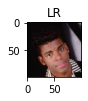

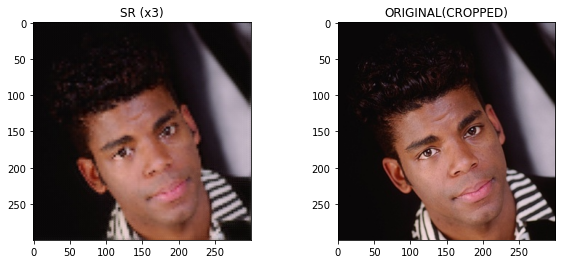

In [8]:
print("PSNR of super resolved image: %f", tf.image.psnr(sr, hr, 255).numpy())  

plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr);


plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'SR (x{SCALE})')
plt.imshow(sr);


plt.subplot(1, 2, 2)   
plt.title('ORIGINAL(CROPPED)')
plt.imshow(hr);

## Check the PSNR for the entire test set

In [9]:
import os
test_directory = 'dataset/BSDS300/images/test/'
psnr_list = []
for file in os.listdir(test_directory):
    print(file)
    lr, sr, hr = super_resolve(os.path.join(test_directory + file))
    psnr = tf.image.psnr(sr, hr, 255).numpy()
    print('PSNR:', psnr)
    psnr_list.append(psnr)
    
print('Average PSNR for the test set: ', np.mean(psnr_list))

69015.jpg
INFO:tensorflow:Assets written to: /tmp/tmpnddaau9i/assets


INFO:tensorflow:Assets written to: /tmp/tmpnddaau9i/assets


PSNR: 26.84621
42049.jpg
INFO:tensorflow:Assets written to: /tmp/tmpi0nf798c/assets


INFO:tensorflow:Assets written to: /tmp/tmpi0nf798c/assets


PSNR: 25.599121
21077.jpg
INFO:tensorflow:Assets written to: /tmp/tmps867n55v/assets


INFO:tensorflow:Assets written to: /tmp/tmps867n55v/assets


PSNR: 23.273537
304074.jpg
INFO:tensorflow:Assets written to: /tmp/tmpqhrwxaah/assets


INFO:tensorflow:Assets written to: /tmp/tmpqhrwxaah/assets


PSNR: 23.469183
299086.jpg
INFO:tensorflow:Assets written to: /tmp/tmp3nwgi_js/assets


INFO:tensorflow:Assets written to: /tmp/tmp3nwgi_js/assets


PSNR: 31.471445
66053.jpg
INFO:tensorflow:Assets written to: /tmp/tmp_xcr9opz/assets


INFO:tensorflow:Assets written to: /tmp/tmp_xcr9opz/assets


PSNR: 25.24249
123074.jpg
INFO:tensorflow:Assets written to: /tmp/tmpahbx4uqe/assets


INFO:tensorflow:Assets written to: /tmp/tmpahbx4uqe/assets


PSNR: 26.971886
102061.jpg
INFO:tensorflow:Assets written to: /tmp/tmpo4fzqe77/assets


INFO:tensorflow:Assets written to: /tmp/tmpo4fzqe77/assets


PSNR: 21.384697
130026.jpg
INFO:tensorflow:Assets written to: /tmp/tmpgcud1ah1/assets


INFO:tensorflow:Assets written to: /tmp/tmpgcud1ah1/assets


PSNR: 22.50059
306005.jpg
INFO:tensorflow:Assets written to: /tmp/tmpepiaejj0/assets


INFO:tensorflow:Assets written to: /tmp/tmpepiaejj0/assets


PSNR: 24.554132
58060.jpg
INFO:tensorflow:Assets written to: /tmp/tmpup2cisa9/assets


INFO:tensorflow:Assets written to: /tmp/tmpup2cisa9/assets


PSNR: 18.220762
134035.jpg
INFO:tensorflow:Assets written to: /tmp/tmpjcumda_9/assets


INFO:tensorflow:Assets written to: /tmp/tmpjcumda_9/assets


PSNR: 20.600264
24077.jpg
INFO:tensorflow:Assets written to: /tmp/tmp3ij00dx9/assets


INFO:tensorflow:Assets written to: /tmp/tmp3ij00dx9/assets


PSNR: 20.908447
253055.jpg
INFO:tensorflow:Assets written to: /tmp/tmpjy5tiyec/assets


INFO:tensorflow:Assets written to: /tmp/tmpjy5tiyec/assets


PSNR: 24.998497
196073.jpg
INFO:tensorflow:Assets written to: /tmp/tmpmoz1y1_7/assets


INFO:tensorflow:Assets written to: /tmp/tmpmoz1y1_7/assets


PSNR: 25.254484
159008.jpg
INFO:tensorflow:Assets written to: /tmp/tmpxj120u_w/assets


INFO:tensorflow:Assets written to: /tmp/tmpxj120u_w/assets


PSNR: 25.569323
302008.jpg
INFO:tensorflow:Assets written to: /tmp/tmpdvia4q1s/assets


INFO:tensorflow:Assets written to: /tmp/tmpdvia4q1s/assets


PSNR: 29.26409
236037.jpg
INFO:tensorflow:Assets written to: /tmp/tmp9hjn2nxo/assets


INFO:tensorflow:Assets written to: /tmp/tmp9hjn2nxo/assets


PSNR: 22.707977
189080.jpg
INFO:tensorflow:Assets written to: /tmp/tmpnpt0k2tr/assets


INFO:tensorflow:Assets written to: /tmp/tmpnpt0k2tr/assets


PSNR: 27.870401
241048.jpg
INFO:tensorflow:Assets written to: /tmp/tmppws4t5jo/assets


INFO:tensorflow:Assets written to: /tmp/tmppws4t5jo/assets


PSNR: 21.843554
126007.jpg
INFO:tensorflow:Assets written to: /tmp/tmptff1e1a_/assets


INFO:tensorflow:Assets written to: /tmp/tmptff1e1a_/assets


PSNR: 26.947392
296007.jpg
INFO:tensorflow:Assets written to: /tmp/tmp_jhs3cl8/assets


INFO:tensorflow:Assets written to: /tmp/tmp_jhs3cl8/assets


PSNR: 29.568333
89072.jpg
INFO:tensorflow:Assets written to: /tmp/tmpzdajk8b9/assets


INFO:tensorflow:Assets written to: /tmp/tmpzdajk8b9/assets


PSNR: 23.750921
14037.jpg
INFO:tensorflow:Assets written to: /tmp/tmpaqf54wn9/assets


INFO:tensorflow:Assets written to: /tmp/tmpaqf54wn9/assets


PSNR: 29.737984
210088.jpg
INFO:tensorflow:Assets written to: /tmp/tmpzz7pasnv/assets


INFO:tensorflow:Assets written to: /tmp/tmpzz7pasnv/assets


PSNR: 28.079853
376043.jpg
INFO:tensorflow:Assets written to: /tmp/tmp6gb2uerk/assets


INFO:tensorflow:Assets written to: /tmp/tmp6gb2uerk/assets


PSNR: 22.37686
108082.jpg
INFO:tensorflow:Assets written to: /tmp/tmpyqxuetcv/assets


INFO:tensorflow:Assets written to: /tmp/tmpyqxuetcv/assets


PSNR: 23.932032
65033.jpg
INFO:tensorflow:Assets written to: /tmp/tmp78lrzrsz/assets


INFO:tensorflow:Assets written to: /tmp/tmp78lrzrsz/assets


PSNR: 22.291483
106024.jpg
INFO:tensorflow:Assets written to: /tmp/tmp914t9rnl/assets


INFO:tensorflow:Assets written to: /tmp/tmp914t9rnl/assets


PSNR: 26.53875
304034.jpg
INFO:tensorflow:Assets written to: /tmp/tmphw7seu4_/assets


INFO:tensorflow:Assets written to: /tmp/tmphw7seu4_/assets


PSNR: 23.008526
148089.jpg
INFO:tensorflow:Assets written to: /tmp/tmpgd3tywdj/assets


INFO:tensorflow:Assets written to: /tmp/tmpgd3tywdj/assets


PSNR: 20.615252
85048.jpg
INFO:tensorflow:Assets written to: /tmp/tmp5na4z9ow/assets


INFO:tensorflow:Assets written to: /tmp/tmp5na4z9ow/assets


PSNR: 22.745953
109053.jpg
INFO:tensorflow:Assets written to: /tmp/tmpsuyfe2c2/assets


INFO:tensorflow:Assets written to: /tmp/tmpsuyfe2c2/assets


PSNR: 28.326994
271035.jpg
INFO:tensorflow:Assets written to: /tmp/tmpzd34afoa/assets


INFO:tensorflow:Assets written to: /tmp/tmpzd34afoa/assets


PSNR: 23.842163
145086.jpg
INFO:tensorflow:Assets written to: /tmp/tmpw384qdhb/assets


INFO:tensorflow:Assets written to: /tmp/tmpw384qdhb/assets


PSNR: 22.057495
291000.jpg
INFO:tensorflow:Assets written to: /tmp/tmpl89h_krb/assets


INFO:tensorflow:Assets written to: /tmp/tmpl89h_krb/assets


PSNR: 19.063812
86068.jpg
INFO:tensorflow:Assets written to: /tmp/tmpeugvdsp_/assets


INFO:tensorflow:Assets written to: /tmp/tmpeugvdsp_/assets


PSNR: 24.16403
69040.jpg
INFO:tensorflow:Assets written to: /tmp/tmp015qkvi2/assets


INFO:tensorflow:Assets written to: /tmp/tmp015qkvi2/assets


PSNR: 22.880817
285079.jpg
INFO:tensorflow:Assets written to: /tmp/tmpa822ra06/assets


INFO:tensorflow:Assets written to: /tmp/tmpa822ra06/assets


PSNR: 22.292358
78004.jpg
INFO:tensorflow:Assets written to: /tmp/tmp6r4tpyrf/assets


INFO:tensorflow:Assets written to: /tmp/tmp6r4tpyrf/assets


PSNR: 22.397104
295087.jpg
INFO:tensorflow:Assets written to: /tmp/tmpqss7p5oz/assets


INFO:tensorflow:Assets written to: /tmp/tmpqss7p5oz/assets


PSNR: 25.063042
19021.jpg
INFO:tensorflow:Assets written to: /tmp/tmppuuhc_k_/assets


INFO:tensorflow:Assets written to: /tmp/tmppuuhc_k_/assets


PSNR: 24.392893
208001.jpg
INFO:tensorflow:Assets written to: /tmp/tmpfujtefnv/assets


INFO:tensorflow:Assets written to: /tmp/tmpfujtefnv/assets


PSNR: 26.06582
86016.jpg
INFO:tensorflow:Assets written to: /tmp/tmpl2v903te/assets


INFO:tensorflow:Assets written to: /tmp/tmpl2v903te/assets


PSNR: 20.126244
182053.jpg
INFO:tensorflow:Assets written to: /tmp/tmprl74ti6u/assets


INFO:tensorflow:Assets written to: /tmp/tmprl74ti6u/assets


PSNR: 21.271156
86000.jpg
INFO:tensorflow:Assets written to: /tmp/tmpjohu5m2p/assets


INFO:tensorflow:Assets written to: /tmp/tmpjohu5m2p/assets


PSNR: 22.045616
42012.jpg
INFO:tensorflow:Assets written to: /tmp/tmpc4dboik_/assets


INFO:tensorflow:Assets written to: /tmp/tmpc4dboik_/assets


PSNR: 28.548944
227092.jpg
INFO:tensorflow:Assets written to: /tmp/tmpibqepqdl/assets


INFO:tensorflow:Assets written to: /tmp/tmpibqepqdl/assets


PSNR: 29.853395
163085.jpg
INFO:tensorflow:Assets written to: /tmp/tmpxkxybk2z/assets


INFO:tensorflow:Assets written to: /tmp/tmpxkxybk2z/assets


PSNR: 27.071915
105025.jpg
INFO:tensorflow:Assets written to: /tmp/tmpp_ae3rho/assets


INFO:tensorflow:Assets written to: /tmp/tmpp_ae3rho/assets


PSNR: 22.76149
87046.jpg
INFO:tensorflow:Assets written to: /tmp/tmpol_qmbd9/assets


INFO:tensorflow:Assets written to: /tmp/tmpol_qmbd9/assets


PSNR: 23.531271
143090.jpg
INFO:tensorflow:Assets written to: /tmp/tmplnyxp2vy/assets


INFO:tensorflow:Assets written to: /tmp/tmplnyxp2vy/assets


PSNR: 29.583525
170057.jpg
INFO:tensorflow:Assets written to: /tmp/tmpi353gwgi/assets


INFO:tensorflow:Assets written to: /tmp/tmpi353gwgi/assets


PSNR: 27.792797
41033.jpg
INFO:tensorflow:Assets written to: /tmp/tmp7cipqqma/assets


INFO:tensorflow:Assets written to: /tmp/tmp7cipqqma/assets


PSNR: 29.048672
54082.jpg
INFO:tensorflow:Assets written to: /tmp/tmp78jeo1zu/assets


INFO:tensorflow:Assets written to: /tmp/tmp78jeo1zu/assets


PSNR: 25.82195
103070.jpg
INFO:tensorflow:Assets written to: /tmp/tmp9qqyemhf/assets


INFO:tensorflow:Assets written to: /tmp/tmp9qqyemhf/assets


PSNR: 26.978676
12084.jpg
INFO:tensorflow:Assets written to: /tmp/tmp2xxxiahj/assets


INFO:tensorflow:Assets written to: /tmp/tmp2xxxiahj/assets


PSNR: 25.832993
69020.jpg
INFO:tensorflow:Assets written to: /tmp/tmp6y3chdi1/assets


INFO:tensorflow:Assets written to: /tmp/tmp6y3chdi1/assets


PSNR: 24.87572
241004.jpg
INFO:tensorflow:Assets written to: /tmp/tmpbe29nln7/assets


INFO:tensorflow:Assets written to: /tmp/tmpbe29nln7/assets


PSNR: 26.639938
220075.jpg
INFO:tensorflow:Assets written to: /tmp/tmptpk18cnp/assets


INFO:tensorflow:Assets written to: /tmp/tmptpk18cnp/assets


PSNR: 25.547213
76053.jpg
INFO:tensorflow:Assets written to: /tmp/tmp9jfllubl/assets


INFO:tensorflow:Assets written to: /tmp/tmp9jfllubl/assets


PSNR: 26.688759
385039.jpg
INFO:tensorflow:Assets written to: /tmp/tmpulay00sy/assets


INFO:tensorflow:Assets written to: /tmp/tmpulay00sy/assets


PSNR: 20.391983
157055.jpg
INFO:tensorflow:Assets written to: /tmp/tmpneozk6xs/assets


INFO:tensorflow:Assets written to: /tmp/tmpneozk6xs/assets


PSNR: 23.168118
101087.jpg
INFO:tensorflow:Assets written to: /tmp/tmpxeinql3l/assets


INFO:tensorflow:Assets written to: /tmp/tmpxeinql3l/assets


PSNR: 21.775494
147091.jpg
INFO:tensorflow:Assets written to: /tmp/tmphazh47v4/assets


INFO:tensorflow:Assets written to: /tmp/tmphazh47v4/assets


PSNR: 22.946972
108070.jpg
INFO:tensorflow:Assets written to: /tmp/tmp3zkbm9s5/assets


INFO:tensorflow:Assets written to: /tmp/tmp3zkbm9s5/assets


PSNR: 21.983892
296059.jpg
INFO:tensorflow:Assets written to: /tmp/tmplzjsg0ss/assets


INFO:tensorflow:Assets written to: /tmp/tmplzjsg0ss/assets


PSNR: 28.050568
148026.jpg
INFO:tensorflow:Assets written to: /tmp/tmpxwhgl56n/assets


INFO:tensorflow:Assets written to: /tmp/tmpxwhgl56n/assets


PSNR: 18.850311
108005.jpg
INFO:tensorflow:Assets written to: /tmp/tmpwzx45wyq/assets


INFO:tensorflow:Assets written to: /tmp/tmpwzx45wyq/assets


PSNR: 23.436354
300091.jpg
INFO:tensorflow:Assets written to: /tmp/tmp8g6u9b03/assets


INFO:tensorflow:Assets written to: /tmp/tmp8g6u9b03/assets


PSNR: 26.263817
167083.jpg
INFO:tensorflow:Assets written to: /tmp/tmp4vuxoxon/assets


INFO:tensorflow:Assets written to: /tmp/tmp4vuxoxon/assets


PSNR: 16.93978
16077.jpg
INFO:tensorflow:Assets written to: /tmp/tmp7f1p2kbg/assets


INFO:tensorflow:Assets written to: /tmp/tmp7f1p2kbg/assets


PSNR: 24.208872
62096.jpg
INFO:tensorflow:Assets written to: /tmp/tmpgmk67dou/assets


INFO:tensorflow:Assets written to: /tmp/tmpgmk67dou/assets


PSNR: 21.325989
253027.jpg
INFO:tensorflow:Assets written to: /tmp/tmp1th10cer/assets


INFO:tensorflow:Assets written to: /tmp/tmp1th10cer/assets


PSNR: 19.151474
97033.jpg
INFO:tensorflow:Assets written to: /tmp/tmpv6k5petq/assets


INFO:tensorflow:Assets written to: /tmp/tmpv6k5petq/assets


PSNR: 21.764275
37073.jpg
INFO:tensorflow:Assets written to: /tmp/tmpqmx3b68l/assets


INFO:tensorflow:Assets written to: /tmp/tmpqmx3b68l/assets


PSNR: 26.77346
45096.jpg
INFO:tensorflow:Assets written to: /tmp/tmpm5cni6ky/assets


INFO:tensorflow:Assets written to: /tmp/tmpm5cni6ky/assets


PSNR: 30.486963
8023.jpg
INFO:tensorflow:Assets written to: /tmp/tmp4i4kmw7z/assets


INFO:tensorflow:Assets written to: /tmp/tmp4i4kmw7z/assets


PSNR: 26.542423
175043.jpg
INFO:tensorflow:Assets written to: /tmp/tmpew_sf57z/assets


INFO:tensorflow:Assets written to: /tmp/tmpew_sf57z/assets


PSNR: 23.019178
43074.jpg
INFO:tensorflow:Assets written to: /tmp/tmp_vevedsi/assets


INFO:tensorflow:Assets written to: /tmp/tmp_vevedsi/assets


PSNR: 26.988844
55073.jpg
INFO:tensorflow:Assets written to: /tmp/tmpyfiii169/assets


INFO:tensorflow:Assets written to: /tmp/tmpyfiii169/assets


PSNR: 18.966494
351093.jpg
INFO:tensorflow:Assets written to: /tmp/tmpbcwsg1z5/assets


INFO:tensorflow:Assets written to: /tmp/tmpbcwsg1z5/assets


PSNR: 19.455585
3096.jpg
INFO:tensorflow:Assets written to: /tmp/tmp323n6jr1/assets


INFO:tensorflow:Assets written to: /tmp/tmp323n6jr1/assets


PSNR: 35.492462
229036.jpg
INFO:tensorflow:Assets written to: /tmp/tmpv49ya3o9/assets


INFO:tensorflow:Assets written to: /tmp/tmpv49ya3o9/assets


PSNR: 20.370588
156065.jpg
INFO:tensorflow:Assets written to: /tmp/tmpi4tmkk_t/assets


INFO:tensorflow:Assets written to: /tmp/tmpi4tmkk_t/assets


PSNR: 23.618322
101085.jpg
INFO:tensorflow:Assets written to: /tmp/tmprjp8py6j/assets


INFO:tensorflow:Assets written to: /tmp/tmprjp8py6j/assets


PSNR: 22.331625
260058.jpg
INFO:tensorflow:Assets written to: /tmp/tmpit7he3h9/assets


INFO:tensorflow:Assets written to: /tmp/tmpit7he3h9/assets


PSNR: 30.070509
216081.jpg
INFO:tensorflow:Assets written to: /tmp/tmput471xwo/assets


INFO:tensorflow:Assets written to: /tmp/tmput471xwo/assets


PSNR: 22.81918
33039.jpg
INFO:tensorflow:Assets written to: /tmp/tmpglc89lrr/assets


INFO:tensorflow:Assets written to: /tmp/tmpglc89lrr/assets


PSNR: 18.12795
41069.jpg
INFO:tensorflow:Assets written to: /tmp/tmpn3rqijwx/assets


INFO:tensorflow:Assets written to: /tmp/tmpn3rqijwx/assets


PSNR: 22.192053
197017.jpg
INFO:tensorflow:Assets written to: /tmp/tmp8s5mwrrh/assets


INFO:tensorflow:Assets written to: /tmp/tmp8s5mwrrh/assets


PSNR: 25.282701
361010.jpg
INFO:tensorflow:Assets written to: /tmp/tmpr0871e6o/assets


INFO:tensorflow:Assets written to: /tmp/tmpr0871e6o/assets


PSNR: 25.288538
160068.jpg
INFO:tensorflow:Assets written to: /tmp/tmp5ujdtlz9/assets


INFO:tensorflow:Assets written to: /tmp/tmp5ujdtlz9/assets


PSNR: 23.563007
223061.jpg
INFO:tensorflow:Assets written to: /tmp/tmp_dt5q94z/assets


INFO:tensorflow:Assets written to: /tmp/tmp_dt5q94z/assets


PSNR: 22.057648
219090.jpg
INFO:tensorflow:Assets written to: /tmp/tmp9f4ska6s/assets


INFO:tensorflow:Assets written to: /tmp/tmp9f4ska6s/assets


PSNR: 23.668955
167062.jpg
INFO:tensorflow:Assets written to: /tmp/tmpjqjtfop_/assets


INFO:tensorflow:Assets written to: /tmp/tmpjqjtfop_/assets


PSNR: 23.832907
119082.jpg
INFO:tensorflow:Assets written to: /tmp/tmp9cgbx7x5/assets


INFO:tensorflow:Assets written to: /tmp/tmp9cgbx7x5/assets


PSNR: 20.61663
38082.jpg
INFO:tensorflow:Assets written to: /tmp/tmpdo18dnni/assets


INFO:tensorflow:Assets written to: /tmp/tmpdo18dnni/assets


PSNR: 24.722626
38092.jpg
INFO:tensorflow:Assets written to: /tmp/tmpde6y0d3s/assets


INFO:tensorflow:Assets written to: /tmp/tmpde6y0d3s/assets


PSNR: 23.401993
175032.jpg
INFO:tensorflow:Assets written to: /tmp/tmpqjat7fpq/assets


INFO:tensorflow:Assets written to: /tmp/tmpqjat7fpq/assets


PSNR: 18.53157
Average PSNR for the test set:  24.211914
